In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from morpheus.classifier import Classifier
from morpheus.data import example
%matplotlib inline

# Getting Data H,J,V,z

In [20]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
f105w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_drz.fits'))
f125w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f125w_v1_drz.fits'))
f140w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f140w_v1_drz.fits'))
f160w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_drz.fits'))
h, j, v, z = f105w_nircam_i2d, f125w_nircam_i2d, f140w_nircam_i2d, f160w_nircam_i2d

hdat = fits.getdata(h, ext=0)
jdat = fits.getdata(j, ext=0)
vdat = fits.getdata(v, ext=0)
zdat = fits.getdata(z, ext=0)

h_header = fits.getheader(h, ext=0)
j_header = fits.getheader(j, ext=0)
v_header = fits.getheader(v, ext=0)
z_header = fits.getheader(z, ext=0)

In [74]:
h_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5000                                                  
NAXIS2  =                 5000                                                  
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
FILENAME= 'hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_drz_sci.fits' / name 
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'WFC3  '          

# Image Show (Unncecessary Would Delete)

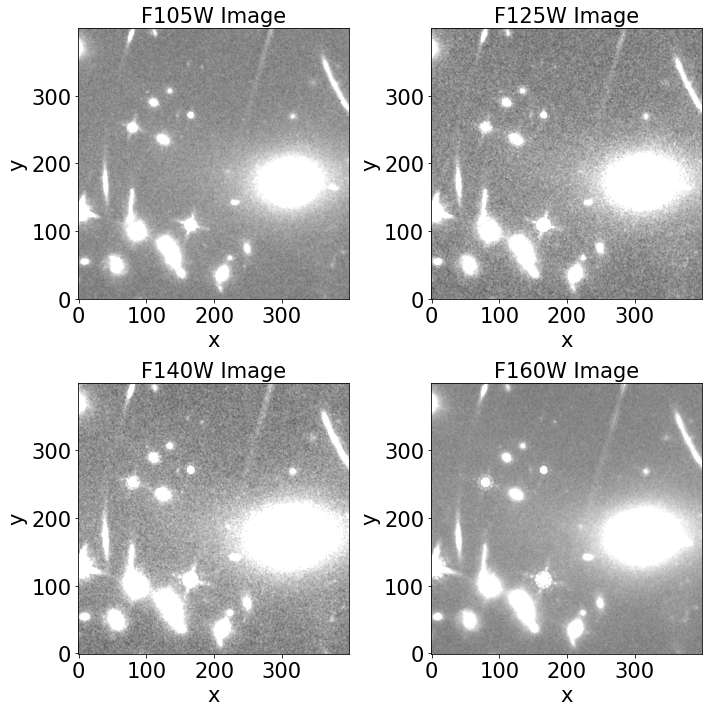

In [21]:
from astropy.nddata import Cutout2D
from astropy import units as u
cutoutposition = (2500, 2500)
cutoutsize = (400, 400)
hcut = Cutout2D(hdat, cutoutposition, cutoutsize).data
jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, [hcut,jcut,vcut,zcut], ['F105W', 'F125W', 'F140W', 'F160W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()

# 1) Running Total Image

## Running Morpheus

In [22]:
classified = Classifier.classify(h=hcut, j=jcut, v=vcut, z=zcut)

# the mask tells the segmentation mapping algorithm to ignore
# the areas unclassified as a result of the windowing classification
# method used.
mask = np.zeros_like(hcut, np.int)
mask[5:-5, 5:-5] = 1
segmap = Classifier.segmap_from_classified(classified, hcut, mask=mask)

catalog = Classifier.catalog_from_classified(classified, hcut, segmap)

rgb = Classifier.colorize_classified(classified)


classifying: 131batch [17:13,  7.89s/batch]                      
/tmp/ipykernel_11121/605678207.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 400/400 [00:00<00:00, 751.24it/s]


In [23]:
# save with it 
import pickle
with open("classified_result_total.pickle","wb") as f:
    pickle.dump(classified, f)

## Colorizing Result

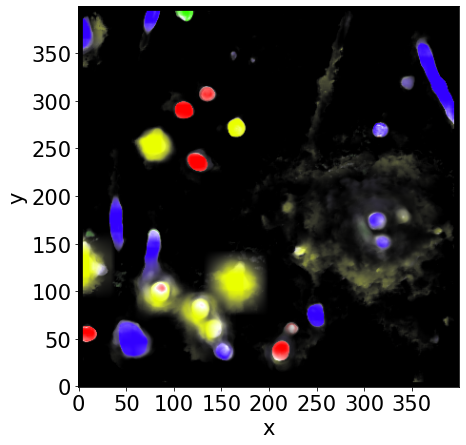

In [24]:
plt.figure(figsize=(7, 7))
plt.xlabel('x', fontsize=21)
plt.ylabel('y', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.imshow(rgb, origin='lower')
plt.show()

## Saving Result to Dataframe, CSV

In [25]:
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs import WCS

wcs = WCS(h_header)

morpheus_result = pd.DataFrame(catalog)
morpheus_result['ra'] = pd.Series(dtype='float')
morpheus_result['dec'] = pd.Series(dtype='float')
morpheus_result['x'] = pd.Series(dtype='float')
morpheus_result['y'] = pd.Series(dtype='float')
morpheus_result['p_sph'] = pd.Series(dtype='float')
morpheus_result['p_disk'] = pd.Series(dtype='float')
morpheus_result['p_irr'] = pd.Series(dtype='float')
morpheus_result['p_ps'] = pd.Series(dtype='float')

for i in range(np.size(morpheus_result['ra'])):
    morpheus_result['x'][i] = morpheus_result['location'][i][1]
    morpheus_result['y'][i] = morpheus_result['location'][i][0]
    morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
    morpheus_result['p_disk'][i] = morpheus_result['morphology'][i][1]
    morpheus_result['p_irr'][i] = morpheus_result['morphology'][i][2]
    morpheus_result['p_ps'][i] = morpheus_result['morphology'][i][3]
   
morpheus_result['real_x'] = morpheus_result['x']+(cutoutposition[0]-cutoutsize[0]/2)
morpheus_result['real_y'] = morpheus_result['y']+(cutoutposition[1]-cutoutsize[1]/2)

for i in range(np.size(morpheus_result['ra'])):
    morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).ra.degree
    morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).dec.degree


/tmp/ipykernel_11121/2421671279.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/2421671279.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/2421671279.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0

In [26]:
import os 
# os.makedirs("./output")
morpheus_result.to_csv("./morpheus_result.csv")

## Filtering High-Probabilithy Disk Candidates

In [50]:
datmor = pd.DataFrame(pd.read_csv("morpheus_result.csv"))
datmor_highdisk=datmor.loc[datmor['p_disk'] > 0.5]
datmor_highdisk

,Unnamed: 0,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
1,1,2,"[38, 152]","[0.13350952296411764, 0.7394473996827445, 0.05...",110.836241,-73.456886,152.0,38.0,0.133510,0.739447,0.051676,0.075367,2452.0,2338.0
2,2,3,"[47, 56]","[4.449912931686453e-06, 0.9711586056081335, 0....",110.841861,-73.456736,56.0,47.0,0.000004,0.971159,0.028812,0.000025,2356.0,2347.0
5,5,6,"[75, 249]","[0.0031394860949273315, 0.9855209561342493, 0....",110.830564,-73.456269,249.0,75.0,0.003139,0.985521,0.009156,0.002184,2549.0,2375.0
10,10,11,"[166, 41]","[2.831416647493969e-06, 0.9808198775880248, 0....",110.842737,-73.454752,41.0,166.0,0.000003,0.980820,0.018279,0.000898,2341.0,2466.0
11,11,12,"[152, 320]","[0.14826546583591302, 0.7726052666493453, 0.00...",110.826409,-73.454986,320.0,152.0,0.148265,0.772605,0.000918,0.078212,2620.0,2452.0
12,12,13,"[172, 313]","[0.14518250549341702, 0.796515884954872, 4.937...",110.826818,-73.454653,313.0,172.0,0.145183,0.796516,0.000005,0.058297,2613.0,2472.0
16,16,17,"[269, 317]","[0.21465392847822623, 0.770822205641764, 0.013...",110.826585,-73.453036,317.0,269.0,0.214654,0.770822,0.013815,0.000708,2617.0,2569.0
17,17,18,"[289, 392]","[0.00010299864016631229, 0.974810267896747, 0....",110.822196,-73.452702,392.0,289.0,0.000103,0.974810,0.024478,0.000609,2692.0,2589.0
20,20,21,"[369, 5]","[0.0005651646029873465, 0.9704477687665133, 0....",110.844842,-73.451369,5.0,369.0,0.000565,0.970448,0.023257,0.005730,2305.0,2669.0
21,21,22,"[392, 79]","[8.018094066012201e-05, 0.9662492872442597, 0....",110.840512,-73.450986,79.0,392.0,0.000080,0.966249,0.032958,0.000713,2379.0,2692.0


## Plotting detected sources on image and colormap

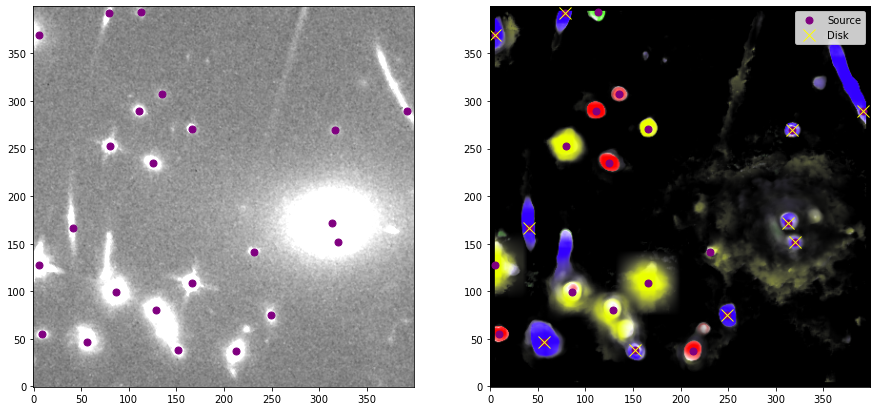

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(hcut, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)
axs[0].plot(datmor['x'], datmor['y'], 'o', ms=7, color='purple')
axs[1].imshow(rgb, origin='lower')
axs[1].plot(datmor['x'], datmor['y'], 'o', ms=7, color='purple', label='Source')
axs[1].plot(datmor_highdisk['x'], datmor_highdisk['y'], 'x', ms=12, color='yellow', label='Disk')
axs[1].legend()


Red = Spheroid <br>
Blue = Disk <br>
Green = Irregular <br>
Yellow = Point Source (compact) <br>
Back = Background <br>
White = Can't Classify (two class prob is so similar) <br>

# 2) Running Each Sourcecut

In [29]:
datmor = pd.DataFrame(pd.read_csv("morpheus_result.csv"))
datmor_highdisk=datmor.loc[datmor['p_disk'] > 0.5]
datmor_highdisk

,Unnamed: 0,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
1,1,2,"[38, 152]","[0.13350952296411764, 0.7394473996827445, 0.05...",110.836241,-73.456886,152.0,38.0,0.133510,0.739447,0.051676,0.075367,2452.0,2338.0
2,2,3,"[47, 56]","[4.449912931686453e-06, 0.9711586056081335, 0....",110.841861,-73.456736,56.0,47.0,0.000004,0.971159,0.028812,0.000025,2356.0,2347.0
5,5,6,"[75, 249]","[0.0031394860949273315, 0.9855209561342493, 0....",110.830564,-73.456269,249.0,75.0,0.003139,0.985521,0.009156,0.002184,2549.0,2375.0
10,10,11,"[166, 41]","[2.831416647493969e-06, 0.9808198775880248, 0....",110.842737,-73.454752,41.0,166.0,0.000003,0.980820,0.018279,0.000898,2341.0,2466.0
11,11,12,"[152, 320]","[0.14826546583591302, 0.7726052666493453, 0.00...",110.826409,-73.454986,320.0,152.0,0.148265,0.772605,0.000918,0.078212,2620.0,2452.0
12,12,13,"[172, 313]","[0.14518250549341702, 0.796515884954872, 4.937...",110.826818,-73.454653,313.0,172.0,0.145183,0.796516,0.000005,0.058297,2613.0,2472.0
16,16,17,"[269, 317]","[0.21465392847822623, 0.770822205641764, 0.013...",110.826585,-73.453036,317.0,269.0,0.214654,0.770822,0.013815,0.000708,2617.0,2569.0
17,17,18,"[289, 392]","[0.00010299864016631229, 0.974810267896747, 0....",110.822196,-73.452702,392.0,289.0,0.000103,0.974810,0.024478,0.000609,2692.0,2589.0
20,20,21,"[369, 5]","[0.0005651646029873465, 0.9704477687665133, 0....",110.844842,-73.451369,5.0,369.0,0.000565,0.970448,0.023257,0.005730,2305.0,2669.0
21,21,22,"[392, 79]","[8.018094066012201e-05, 0.9662492872442597, 0....",110.840512,-73.450986,79.0,392.0,0.000080,0.966249,0.032958,0.000713,2379.0,2692.0


In [35]:
def source_morpheus_run(x, y):
    cutoutposition = (x, y)
    cutoutsize = (60, 60)
    hcut = Cutout2D(hdat, cutoutposition, cutoutsize).data
    jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
    vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
    zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data
    classified = Classifier.classify(h=hcut, j=jcut, v=vcut, z=zcut)
    # the mask tells the segmentation mapping algorithm to ignore
    # the areas unclassified as a result of the windowing classification
    # method used.
    mask = np.zeros_like(hcut, np.int)
    mask[5:-5, 5:-5] = 1
    segmap = Classifier.segmap_from_classified(classified, hcut, mask=mask)
    catalog = Classifier.catalog_from_classified(classified, hcut, segmap)
    rgb = Classifier.colorize_classified(classified)

    wcs = WCS(h_header)

    morpheus_result = pd.DataFrame(catalog)
    morpheus_result['ra'] = pd.Series(dtype='float')
    morpheus_result['dec'] = pd.Series(dtype='float')
    morpheus_result['x'] = pd.Series(dtype='float')
    morpheus_result['y'] = pd.Series(dtype='float')
    morpheus_result['p_sph'] = pd.Series(dtype='float')
    morpheus_result['p_disk'] = pd.Series(dtype='float')
    morpheus_result['p_irr'] = pd.Series(dtype='float')
    morpheus_result['p_ps'] = pd.Series(dtype='float')

    for i in range(np.size(morpheus_result['ra'])):
        morpheus_result['x'][i] = morpheus_result['location'][i][1]
        morpheus_result['y'][i] = morpheus_result['location'][i][0]
        morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
        morpheus_result['p_disk'][i] = morpheus_result['morphology'][i][1]
        morpheus_result['p_irr'][i] = morpheus_result['morphology'][i][2]
        morpheus_result['p_ps'][i] = morpheus_result['morphology'][i][3]
    
    morpheus_result['real_x'] = morpheus_result['x']+(cutoutposition[0]-cutoutsize[0]/2)
    morpheus_result['real_y'] = morpheus_result['y']+(cutoutposition[1]-cutoutsize[1]/2)

    for i in range(np.size(morpheus_result['ra'])):
        morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).ra.degree
        morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).dec.degree
    
    return morpheus_result


In [53]:
df = pd.DataFrame(columns =['id','location','morphology','ra','dec','x','y','p_sph','p_disk','p_irr','p_ps','real_x','real_y'])

for i in datmor_highdisk['Unnamed: 0']:
    add = source_morpheus_run(datmor_highdisk['real_x'][i], datmor_highdisk['real_y'][i])
    df = pd.concat([df, add])


classifying: 1batch [00:03,  3.90s/batch]
/tmp/ipykernel_11121/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 6265.92it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4549.96it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5229.70it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4971.13it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5108.15it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5194.83it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5354.77it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 2300.45it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5834.20it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5143.97it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

In [55]:
df_highdisk = df.loc[df['p_disk']>0.5]

In [56]:
datmor_highdisk

,Unnamed: 0,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
1,1,2,"[38, 152]","[0.13350952296411764, 0.7394473996827445, 0.05...",110.836241,-73.456886,152.0,38.0,0.133510,0.739447,0.051676,0.075367,2452.0,2338.0
2,2,3,"[47, 56]","[4.449912931686453e-06, 0.9711586056081335, 0....",110.841861,-73.456736,56.0,47.0,0.000004,0.971159,0.028812,0.000025,2356.0,2347.0
5,5,6,"[75, 249]","[0.0031394860949273315, 0.9855209561342493, 0....",110.830564,-73.456269,249.0,75.0,0.003139,0.985521,0.009156,0.002184,2549.0,2375.0
10,10,11,"[166, 41]","[2.831416647493969e-06, 0.9808198775880248, 0....",110.842737,-73.454752,41.0,166.0,0.000003,0.980820,0.018279,0.000898,2341.0,2466.0
11,11,12,"[152, 320]","[0.14826546583591302, 0.7726052666493453, 0.00...",110.826409,-73.454986,320.0,152.0,0.148265,0.772605,0.000918,0.078212,2620.0,2452.0
12,12,13,"[172, 313]","[0.14518250549341702, 0.796515884954872, 4.937...",110.826818,-73.454653,313.0,172.0,0.145183,0.796516,0.000005,0.058297,2613.0,2472.0
16,16,17,"[269, 317]","[0.21465392847822623, 0.770822205641764, 0.013...",110.826585,-73.453036,317.0,269.0,0.214654,0.770822,0.013815,0.000708,2617.0,2569.0
17,17,18,"[289, 392]","[0.00010299864016631229, 0.974810267896747, 0....",110.822196,-73.452702,392.0,289.0,0.000103,0.974810,0.024478,0.000609,2692.0,2589.0
20,20,21,"[369, 5]","[0.0005651646029873465, 0.9704477687665133, 0....",110.844842,-73.451369,5.0,369.0,0.000565,0.970448,0.023257,0.005730,2305.0,2669.0
21,21,22,"[392, 79]","[8.018094066012201e-05, 0.9662492872442597, 0....",110.840512,-73.450986,79.0,392.0,0.000080,0.966249,0.032958,0.000713,2379.0,2692.0


In [58]:
df_highdisk

,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
0,1,"[30, 30]","[0.13470617254168146, 0.8326859634671487, 0.03...",110.836241,-73.456886,30.0,30.0,0.134706,0.832686,0.031611,0.000997,2452.0,2338.0
0,1,"[30, 30]","[0.0, 1.0, 0.0, 0.0]",110.841861,-73.456736,30.0,30.0,0.0,1.0,0.0,0.0,2356.0,2347.0
1,2,"[30, 30]","[0.0, 1.0, 0.0, 0.0]",110.830564,-73.456269,30.0,30.0,0.0,1.0,0.0,0.0,2549.0,2375.0
0,1,"[5, 5]","[0.0, 1.0, 0.0, 0.0]",110.844201,-73.455169,5.0,5.0,0.0,1.0,0.0,0.0,2316.0,2441.0
1,2,"[30, 30]","[0.0, 1.0, 0.0, 0.0]",110.842737,-73.454752,30.0,30.0,0.0,1.0,0.0,0.0,2341.0,2466.0
0,1,"[30, 30]","[0.07523180349973768, 0.7885031937845207, 0.00...",110.826409,-73.454986,30.0,30.0,0.075232,0.788503,0.000274,0.135991,2620.0,2452.0
1,2,"[50, 23]","[0.11041055553537203, 0.7698678446411972, 0.0,...",110.826818,-73.454653,23.0,50.0,0.110411,0.769868,0.0,0.119722,2613.0,2472.0
1,2,"[10, 37]","[0.021305086594645695, 0.952150037353983, 0.0,...",110.826409,-73.454986,37.0,10.0,0.021305,0.95215,0.0,0.026545,2620.0,2452.0
2,3,"[30, 30]","[0.022900885795314383, 0.8898731527089334, 0.0...",110.826818,-73.454653,30.0,30.0,0.022901,0.889873,0.0,0.087226,2613.0,2472.0
0,1,"[30, 30]","[0.2303270804365307, 0.7683327345967377, 0.001...",110.826585,-73.453036,30.0,30.0,0.230327,0.768333,0.00104,0.000301,2617.0,2569.0


연산 속도 17min 16s / 47s 
연산 정확도 disk candidates 모두 찾음 + 다만, 새로운 방식 내에서는 주어진 영역내에서 disk를 더 찾음 / 이것은 이미지를 확인해보면 source가 쪼개진 것으로 보임 혹은 Source를 더 찾았거나 / 하지만 image를 자를 때 중심의 위치를 고려하면 처음의 목표했던 candidates 자체가 disk 인지 아닌지 정확하게 찾을 수 있음 + 추가적인 Source의 가능성 

p_disk 정확도 오히려 평균적으로 다들 올라간 특성을 보임 / source의 위치 주변 잘라서 보는 것은 정확한 것으로 보임 

In [72]:
np.mean(df_highdisk['p_disk'])

0.9167844105460435

In [73]:
np.mean(datmor_highdisk['p_disk'])

0.8928397520166655

In [86]:
dat_cat = pd.read_csv("/data/jip/2nd_TASK/Morpheus_Trying/HST_Relics_analysis/Raw/catalog_source.csv")
df2 = pd.DataFrame(columns =['id','location','morphology','ra','dec','x','y','p_sph','p_disk','p_irr','p_ps','real_x','real_y'])

for i in range(np.size(dat_cat['x'])):
    add = source_morpheus_run(dat_cat['x'][i], dat_cat['y'][i])
    df2 = pd.concat([df2, add])

classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_11121/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4887.23it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8662.64it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9056.04it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9087.43it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8946.89it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5053.07it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9076.62it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 5215.93it/s]
classifying: 1batch [00:02,  2.29s/batch]
/tmp/ipykernel_11121/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9012.26it/s]
classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_11121/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9042.70it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5589.30it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9181.93it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8301.44it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9189.30it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9137.25it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9055.39it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8976.57it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8980.74it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9029.39it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9101.89it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9198.37it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9163.54it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9116.73it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5505.66it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8756.38it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4301.56it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9180.59it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5043.86it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9198.71it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9137.92it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8898.18it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4852.18it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9249.76it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9172.22it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9100.91it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9128.97it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8656.38it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4977.32it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9320.68it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4689.52it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9095.64it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9188.97it/s]
classifying: 1batch [00:01,  1.97s/batch]
/tmp/ipykernel_11121/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8863.70it/s]
classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_11121/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9097.94it/s]
classifying: 1batch [00:02,  2.39s/batch]
/tmp/ipykernel_11121/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9059.62it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9009.35it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9187.29it/s]
classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_11121/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9131.62it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8648.94it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8989.40it/s]
/tmp/ipykernel_11121/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_11121/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_11121/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_resul

In [87]:
df2_highdisk = df2.loc[df2['p_disk']>0.5]

In [88]:
df2_highdisk

,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
0,1,"[32, 30]","[0.0, 1.0, 0.0, 0.0]",110.840539,-73.450997,30.0,32.0,0.0,1.0,0.0,0.0,2378.54,2691.307
0,1,"[54, 36]","[0.0, 0.7763521318761307, 0.2236478681238693, ...",110.840697,-73.451138,36.0,54.0,0.0,0.776352,0.223648,0.0,2375.844,2682.87
0,1,"[29, 29]","[0.0, 0.6247707204466758, 0.3752292795533242, ...",110.83858,-73.450956,29.0,29.0,0.0,0.624771,0.375229,0.0,2412.012,2693.813
0,1,"[29, 12]","[0.0, 0.9996967643874431, 0.000303235612556812...",110.823724,-73.451804,12.0,29.0,0.0,0.999697,0.000303,0.0,2665.892,2642.933
0,1,"[29, 28]","[0.0, 1.0, 0.0, 0.0]",110.823752,-73.451817,28.0,29.0,0.0,1.0,0.0,0.0,2665.42,2642.144
0,1,"[54, 17]","[0.0, 0.9986260175325364, 0.001355020254803722...",110.823727,-73.451822,17.0,54.0,0.0,0.998626,0.001355,0.000019,2665.852,2641.846
0,1,"[26, 29]","[0.0, 1.0, 0.0, 0.0]",110.822225,-73.452718,29.0,26.0,0.0,1.0,0.0,0.0,2691.502,2588.085
0,1,"[52, 47]","[0.000398918809153903, 0.9870845803681348, 0.0...",110.823775,-73.451814,47.0,52.0,0.000399,0.987085,0.012502,0.000014,2665.025,2642.3
0,1,"[5, 5]","[0.0, 1.0, 0.0, 0.0]",110.837928,-73.453393,5.0,5.0,0.0,1.0,0.0,0.0,2423.168,2547.565
0,1,"[28, 29]","[0.2147973349231954, 0.7841039492797801, 0.000...",110.826597,-73.453051,29.0,28.0,0.214797,0.784104,0.000867,0.000232,2616.798,2568.108


In [107]:
np.mean(df2_highdisk['p_disk'])

0.9090699868506463

Comparison of Detected disk candidates (depends on inputs)

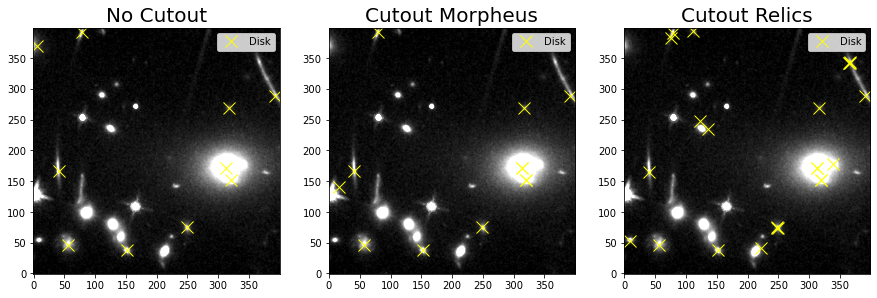

In [106]:
fig, axs = plt.subplots(1, 3, figsize=(15,15))
axs[0].imshow(hcut, origin='lower', cmap='gray',  vmin=0, vmax=0.25)
axs[0].plot(datmor_highdisk['x'], datmor_highdisk['y'], 'x', ms=12, color='yellow', label='Disk')
axs[0].set_title("No Cutout", fontsize=20)
axs[0].legend()

axs[1].imshow(hcut, origin='lower', cmap='gray',  vmin=0, vmax=0.25)
axs[1].plot(df_highdisk['real_x']-2300, df_highdisk['real_y']-2300, 'x', ms=12, color='yellow', label='Disk')
axs[1].set_title("Cutout Morpheus", fontsize=20)
axs[1].legend()

axs[2].imshow(hcut, origin='lower', cmap='gray',  vmin=0, vmax=0.25)
axs[2].plot(df2_highdisk['real_x']-2300, df2_highdisk['real_y']-2300, 'x', ms=12, color='yellow', label='Disk')
axs[2].set_title("Cutout Relics", fontsize=20)
axs[2].legend()



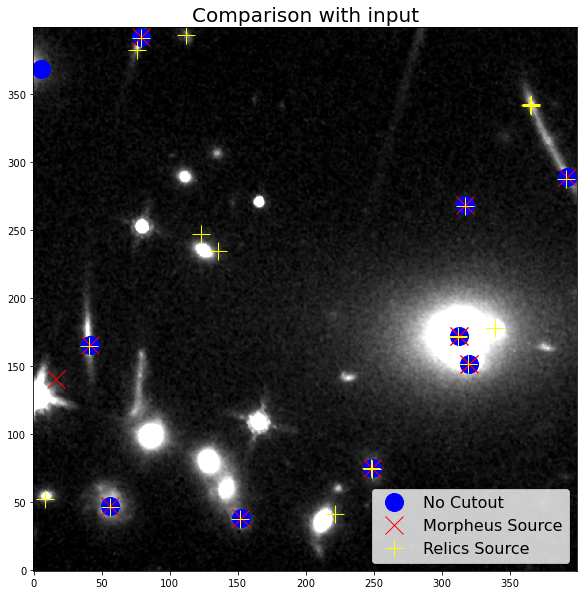

In [114]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
axs.imshow(hcut, origin='lower', cmap='gray',  vmin=0, vmax=0.25)
axs.plot(datmor_highdisk['x'], datmor_highdisk['y'], 'o', ms=18, color='blue', label='No Cutout')
axs.plot(df_highdisk['real_x']-2300, df_highdisk['real_y']-2300, 'x', ms=18, color='red', label='Morpheus Source')
axs.plot(df2_highdisk['real_x']-2300, df2_highdisk['real_y']-2300, '+', ms=18, color='yellow', label='Relics Source')
axs.set_title('Comparison with input',  fontsize=20)
axs.legend(prop={'size': 16})